# Amazon Fine Food Reviews Analysis


Data Source: https://www.kaggle.com/snap/amazon-fine-food-reviews <br>

The Amazon Fine Food Reviews dataset consists of reviews of fine foods from Amazon.<br>

Number of reviews: 568,454<br>
Number of users: 256,059<br>
Number of products: 74,258<br>
Timespan: Oct 1999 - Oct 2012<br>
Number of Attributes/Columns in data: 10 

Attribute Information:

1. Id
2. ProductId - unique identifier for the product
3. UserId - unqiue identifier for the user
4. ProfileName
5. HelpfulnessNumerator - number of users who found the review helpful
6. HelpfulnessDenominator - number of users who indicated whether they found the review helpful or not
7. Score - rating between 1 and 5
8. Time - timestamp for the review
9. Summary - brief summary of the review
10. Text - text of the review


#### Objective:
Given a review, determine whether the review is positive (Rating of 4 or 5) or negative (rating of 1 or 2).

<br>
We shall use the Score/Rating to determine whether a review is positive or negative. A rating of 4 or 5 is considered a positive review. A review of 1 or 2 is considered to be a negative one. A review of 3 is nuetral and ignored. This is an approximate and proxy way of determining the polarity (positivity/negativity) of a review.

## Loading the data

The dataset is available in two forms
1. .csv file
2. SQLite Database

In order to load the data, We have used the SQLITE dataset as it easier to query the data and visualise the data efficiently.
<br> 

Here as we only want to get the global sentiment of the recommendations (positive or negative), we will purposefully ignore all Scores equal to 3. If the score id above 3, then the recommendation wil be set to "positive". Otherwise, it will be set to "negative".

In [3]:
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")



import sqlite3
import pandas as pd
import numpy as np
import nltk
import string
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import confusion_matrix
from sklearn import metrics
from sklearn.metrics import roc_curve, auc
from nltk.stem.porter import PorterStemmer

import re
import string
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.stem.wordnet import WordNetLemmatizer

from gensim.models import Word2Vec
from gensim.models import KeyedVectors
import pickle

from tqdm import tqdm
import os

# [1]. Reading Data

In [4]:

# using the SQLite Table to read data.
con = sqlite3.connect('../input/database.sqlite') 
#filtering only positive and negative reviews i.e. 
# not taking into consideration those reviews with Score=3
# We'll be taking 5k data points given that t-sne is computationally expensive.

filtered_data = pd.read_sql_query(""" SELECT * FROM Reviews WHERE Score != 3 LIMIT 5000""", con) 

# Give reviews with Score>3 a positive rating, and reviews with a score<3 a negative rating.
def partition(x):
    if x < 3:
        return 0
    return 1

#changing reviews with score less than 3 to be positive and vice-versa
actualScore = filtered_data['Score']
positiveNegative = actualScore.map(partition) 
filtered_data['Score'] = positiveNegative
print("Number of data points in our data", filtered_data.shape)
filtered_data.head(3)

Number of data points in our data (5000, 10)


,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,1,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,0,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...
2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,1,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...


In [5]:
display = pd.read_sql_query("""
SELECT UserId, ProductId, ProfileName, Time, Score, Text, COUNT(*)
FROM Reviews
GROUP BY UserId
HAVING COUNT(*)>1
""", con)

In [6]:
print(display.shape)
display.head()

(80668, 7)


,UserId,ProductId,ProfileName,Time,Score,Text,COUNT(*)
0,#oc-R115TNMSPFT9I7,B005ZBZLT4,Breyton,1331510400,2,Overall its just OK when considering the price...,2
1,#oc-R11D9D7SHXIJB9,B005HG9ESG,"Louis E. Emory ""hoppy""",1342396800,5,"My wife has recurring extreme muscle spasms, u...",3
2,#oc-R11DNU2NBKQ23Z,B005ZBZLT4,Kim Cieszykowski,1348531200,1,This coffee is horrible and unfortunately not ...,2
3,#oc-R11O5J5ZVQE25C,B005HG9ESG,Penguin Chick,1346889600,5,This will be the bottle that you grab from the...,3
4,#oc-R12KPBODL2B5ZD,B007OSBEV0,Christopher P. Presta,1348617600,1,I didnt like this coffee. Instead of telling y...,2


In [7]:
display[display['UserId']=='AZY10LLTJ71NX']

,UserId,ProductId,ProfileName,Time,Score,Text,COUNT(*)
80638,AZY10LLTJ71NX,B001ATMQK2,"undertheshrine ""undertheshrine""",1296691200,5,I bought this 6 pack because for the price tha...,5


In [8]:
display['COUNT(*)'].sum()

393063

#  Exploratory Data Analysis

## [2] Data Cleaning: Deduplication

It is observed (as shown in the table below) that the reviews data had many duplicate entries. Hence it was necessary to remove duplicates in order to get unbiased results for the analysis of the data.  Following is an example:

In [9]:
display= pd.read_sql_query("""
SELECT *
FROM Reviews
WHERE Score != 3 AND UserId="AR5J8UI46CURR"
ORDER BY ProductID
""", con)
display.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,78445,B000HDL1RQ,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
1,138317,B000HDOPYC,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
2,138277,B000HDOPYM,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
3,73791,B000HDOPZG,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
4,155049,B000PAQ75C,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...


As can be seen above the same user has multiple reviews of the with the same values for HelpfulnessNumerator, HelpfulnessDenominator, Score, Time, Summary and Text  and on doing analysis it was found that <br>
<br> 
ProductId=B000HDOPZG was Loacker Quadratini Vanilla Wafer Cookies, 8.82-Ounce Packages (Pack of 8)<br>
<br> 
ProductId=B000HDL1RQ was Loacker Quadratini Lemon Wafer Cookies, 8.82-Ounce Packages (Pack of 8) and so on<br>

It was inferred after analysis that reviews with same parameters other than ProductId belonged to the same product just having different flavour or quantity. Hence in order to reduce redundancy it was decided to eliminate the rows having same parameters.<br>

The method used for the same was that we first sort the data according to ProductId and then just keep the first similar product review and delelte the others. for eg. in the above just the review for ProductId=B000HDL1RQ remains. This method ensures that there is only one representative for each product and deduplication without sorting would lead to possibility of different representatives still existing for the same product.

In [10]:
#Sorting data according to ProductId in ascending order
sorted_data=filtered_data.sort_values('ProductId', axis=0, ascending=True, inplace=False, kind='quicksort', na_position='last')

In [11]:
#Deduplication of entries
final=sorted_data.drop_duplicates(subset={"UserId","ProfileName","Time","Text"}, keep='first', inplace=False)
final.shape

(4986, 10)

In [12]:
#Checking to see how much % of data still remains
(final['Id'].size*1.0)/(filtered_data['Id'].size*1.0)*100

99.72

In [13]:
display= pd.read_sql_query("""
SELECT *
FROM Reviews
WHERE Score != 3 AND HelpfulnessNumerator>HelpfulnessDenominator
""", con)

In [14]:
display.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,44737,B001EQ55RW,A2V0I904FH7ABY,Ram,3,2,4,1212883200,Pure cocoa taste with crunchy almonds inside,It was almost a 'love at first bite' - the per...
1,64422,B000MIDROQ,A161DK06JJMCYF,"J. E. Stephens ""Jeanne""",3,1,5,1224892800,Bought This for My Son at College,My son loves spaghetti so I didn't hesitate or...


<b>Observation:-</b> It is seen that in two rows shown above the value of HelpfulnessNumerator is greater than HelpfulnessDenominator which is not practically possible. Hence these two rows too are removed from calculations.

In [ ]:
final=final[final.HelpfulnessNumerator<=final.HelpfulnessDenominator]

In [15]:
#Before starting the next phase of preprocessing lets see the number of entries left
print(final.shape)

#How many positive and negative reviews are present in our dataset?
final['Score'].value_counts()

(4986, 10)


1    4178
0     808
Name: Score, dtype: int64

# [3].  Text Preprocessing.

Now that we have finished deduplication our data requires some preprocessing before we go on further with analysis and making the prediction model.

Hence in the Preprocessing phase we do the following in the order below:-

1. Begin by removing the html tags
2. Remove any punctuations or limited set of special characters like , or . or # etc.
3. Check if the word is made up of english letters and is not alpha-numeric
4. Check to see if the length of the word is greater than 2 (as it was researched that there is no adjective in 2-letters)
5. Convert the word to lowercase
6. Remove Stopwords
7. Finally Snowball Stemming the word (it was obsereved to be better than Porter Stemming)

After which we collect the words used to describe positive and negative reviews

In [16]:
# printing some random reviews
sent_0 = final['Text'].values[0]
print(sent_0)
print("="*50)

sent_1000 = final['Text'].values[1000]
print(sent_1000)
print("="*50)

sent_1500 = final['Text'].values[1500]
print(sent_1500)
print("="*50)

sent_4900 = final['Text'].values[4900]
print(sent_4900)
print("="*50)

Why is this $[...] when the same product is available for $[...] here?<br />http://www.amazon.com/VICTOR-FLY-MAGNET-BAIT-REFILL/dp/B00004RBDY<br /><br />The Victor M380 and M502 traps are unreal, of course -- total fly genocide. Pretty stinky, but only right nearby.
I recently tried this flavor/brand and was surprised at how delicious these chips are.  The best thing was that there were a lot of "brown" chips in the bsg (my favorite), so I bought some more through amazon and shared with family and friends.  I am a little disappointed that there are not, so far, very many brown chips in these bags, but the flavor is still very good.  I like them better than the yogurt and green onion flavor because they do not seem to be as salty, and the onion flavor is better.  If you haven't eaten Kettle chips before, I recommend that you try a bag before buying bulk.  They are thicker and crunchier than Lays but just as fresh out of the bag.
Wow.  So far, two two-star reviews.  One obviously had no 

In [17]:
# remove urls from text python: https://stackoverflow.com/a/40823105/4084039
sent_0 = re.sub(r"http\S+", "", sent_0)
sent_1000 = re.sub(r"http\S+", "", sent_1000)
sent_150 = re.sub(r"http\S+", "", sent_1500)
sent_4900 = re.sub(r"http\S+", "", sent_4900)

print(sent_0)

Why is this $[...] when the same product is available for $[...] here?<br /> /><br />The Victor M380 and M502 traps are unreal, of course -- total fly genocide. Pretty stinky, but only right nearby.


In [18]:
# https://stackoverflow.com/questions/16206380/python-beautifulsoup-how-to-remove-all-tags-from-an-element
from bs4 import BeautifulSoup

soup = BeautifulSoup(sent_0, 'lxml')
text = soup.get_text()
print(text)
print("="*50)

soup = BeautifulSoup(sent_1000, 'lxml')
text = soup.get_text()
print(text)
print("="*50)

soup = BeautifulSoup(sent_1500, 'lxml')
text = soup.get_text()
print(text)
print("="*50)

soup = BeautifulSoup(sent_4900, 'lxml')
text = soup.get_text()
print(text)

Why is this $[...] when the same product is available for $[...] here? />The Victor M380 and M502 traps are unreal, of course -- total fly genocide. Pretty stinky, but only right nearby.
I recently tried this flavor/brand and was surprised at how delicious these chips are.  The best thing was that there were a lot of "brown" chips in the bsg (my favorite), so I bought some more through amazon and shared with family and friends.  I am a little disappointed that there are not, so far, very many brown chips in these bags, but the flavor is still very good.  I like them better than the yogurt and green onion flavor because they do not seem to be as salty, and the onion flavor is better.  If you haven't eaten Kettle chips before, I recommend that you try a bag before buying bulk.  They are thicker and crunchier than Lays but just as fresh out of the bag.
Wow.  So far, two two-star reviews.  One obviously had no idea what they were ordering; the other wants crispy cookies.  Hey, I'm sorry; b

In [19]:
# https://stackoverflow.com/a/47091490/4084039
import re

def decontracted(phrase):
    # specific
    phrase = re.sub(r"won't", "will not", phrase)
    phrase = re.sub(r"can\'t", "can not", phrase)

    # general
    phrase = re.sub(r"n\'t", " not", phrase)
    phrase = re.sub(r"\'re", " are", phrase)
    phrase = re.sub(r"\'s", " is", phrase)
    phrase = re.sub(r"\'d", " would", phrase)
    phrase = re.sub(r"\'ll", " will", phrase)
    phrase = re.sub(r"\'t", " not", phrase)
    phrase = re.sub(r"\'ve", " have", phrase)
    phrase = re.sub(r"\'m", " am", phrase)
    return phrase

In [20]:
sent_1500 = decontracted(sent_1500)
print(sent_1500)
print("="*50)

Wow.  So far, two two-star reviews.  One obviously had no idea what they were ordering; the other wants crispy cookies.  Hey, I am sorry; but these reviews do nobody any good beyond reminding us to look  before ordering.<br /><br />These are chocolate-oatmeal cookies.  If you do not like that combination, do not order this type of cookie.  I find the combo quite nice, really.  The oatmeal sort of "calms" the rich chocolate flavor and gives the cookie sort of a coconut-type consistency.  Now let is also remember that tastes differ; so, I have given my opinion.<br /><br />Then, these are soft, chewy cookies -- as advertised.  They are not "crispy" cookies, or the blurb would say "crispy," rather than "chewy."  I happen to like raw cookie dough; however, I do not see where these taste like raw cookie dough.  Both are soft, however, so is this the confusion?  And, yes, they stick together.  Soft cookies tend to do that.  They are not individually wrapped, which would add to the cost.  Oh y

In [21]:
#remove words with numbers python: https://stackoverflow.com/a/18082370/4084039
sent_0 = re.sub("\S*\d\S*", "", sent_0).strip()
print(sent_0)

Why is this $[...] when the same product is available for $[...] here?<br /> /><br />The Victor  and  traps are unreal, of course -- total fly genocide. Pretty stinky, but only right nearby.


In [22]:
#remove spacial character: https://stackoverflow.com/a/5843547/4084039
sent_1500 = re.sub('[^A-Za-z0-9]+', ' ', sent_1500)
print(sent_1500)

Wow So far two two star reviews One obviously had no idea what they were ordering the other wants crispy cookies Hey I am sorry but these reviews do nobody any good beyond reminding us to look before ordering br br These are chocolate oatmeal cookies If you do not like that combination do not order this type of cookie I find the combo quite nice really The oatmeal sort of calms the rich chocolate flavor and gives the cookie sort of a coconut type consistency Now let is also remember that tastes differ so I have given my opinion br br Then these are soft chewy cookies as advertised They are not crispy cookies or the blurb would say crispy rather than chewy I happen to like raw cookie dough however I do not see where these taste like raw cookie dough Both are soft however so is this the confusion And yes they stick together Soft cookies tend to do that They are not individually wrapped which would add to the cost Oh yeah chocolate chip cookies tend to be somewhat sweet br br So if you wa

In [23]:
# https://gist.github.com/sebleier/554280
# we are removing the words from the stop words list: 'no', 'nor', 'not'
# <br /><br /> ==> after the above steps, we are getting "br br"
# we are including them into stop words list
# instead of <br /> if we have <br/> these tags would have revmoved in the 1st step

stopwords= set(['br', 'the', 'i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've",\
            "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', \
            'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their',\
            'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', \
            'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', \
            'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', \
            'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after',\
            'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further',\
            'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more',\
            'most', 'other', 'some', 'such', 'only', 'own', 'same', 'so', 'than', 'too', 'very', \
            's', 't', 'can', 'will', 'just', 'don', "don't", 'should', "should've", 'now', 'd', 'll', 'm', 'o', 're', \
            've', 'y', 'ain', 'aren', "aren't", 'couldn', "couldn't", 'didn', "didn't", 'doesn', "doesn't", 'hadn',\
            "hadn't", 'hasn', "hasn't", 'haven', "haven't", 'isn', "isn't", 'ma', 'mightn', "mightn't", 'mustn',\
            "mustn't", 'needn', "needn't", 'shan', "shan't", 'shouldn', "shouldn't", 'wasn', "wasn't", 'weren', "weren't", \
            'won', "won't", 'wouldn', "wouldn't"])

In [24]:
# Combining all the above stundents 
from tqdm import tqdm
preprocessed_reviews = []
# tqdm is for printing the status bar
for sentance in tqdm(final['Text'].values):
    sentance = re.sub(r"http\S+", "", sentance)
    sentance = BeautifulSoup(sentance, 'lxml').get_text()
    sentance = decontracted(sentance)
    sentance = re.sub("\S*\d\S*", "", sentance).strip()
    sentance = re.sub('[^A-Za-z]+', ' ', sentance)
    # https://gist.github.com/sebleier/554280
    sentance = ' '.join(e.lower() for e in sentance.split() if e.lower() not in stopwords)
    preprocessed_reviews.append(sentance.strip())

100%|██████████| 4986/4986 [00:01<00:00, 2723.70it/s]


In [28]:
len(preprocessed_reviews)

4986

In [29]:
preprocessed_reviews[1000]

'recently tried flavor brand surprised delicious chips best thing lot brown chips bsg favorite bought amazon shared family friends little disappointed not far many brown chips bags flavor still good like better yogurt green onion flavor not seem salty onion flavor better not eaten kettle chips recommend try bag buying bulk thicker crunchier lays fresh bag'

# [4] Featurization  and applying T-SNE models

## [4.1] BAG OF WORDS

In [33]:
#BoW approach. Considering bigram features are considered as well.
# min_df is set to 10. max_df is not needed since we have already removed the stop words.
# More about min_df and max_df here : - https://stackoverflow.com/questions/27697766/understanding-min-df-and-max-df-in-scikit-countvectorizer
count_vect = CountVectorizer(ngram_range=(1,2), min_df=10, max_features=5000)
final_counts = count_vect.fit_transform(preprocessed_reviews)

print("the type of count vectorizer including unigrams and bigrams ",type(final_counts))
print("the shape of out text BOW vectorizer including unigrams and bigrams ",final_counts.get_shape())
print("the number of unique words including unigrams and bigrams ", final_counts.get_shape()[1])

the type of count vectorizer including unigrams and bigrams  <class 'scipy.sparse.csr.csr_matrix'>
the shape of out text BOW vectorizer including unigrams and bigrams  (4986, 3144)
the number of unique words including unigrams and bigrams  3144


## [4.1.1] Applying T-SNE on BOW

In [41]:
%%time

# Before applying the model, convert the sparse matrix to dense matrix using truncated SVD.

# Standardize the data for truncated SVD 
from sklearn.preprocessing import StandardScaler
final_standardized_data=StandardScaler(with_mean=False).fit_transform(final_counts)

# Apply truncated SVD setting the number of features as 50 
# This will suppress some noise and speed up the computation of pairwise distances between samples.
# Reference : https://scikit-learn.org/stable/modules/generated/sklearn.manifold.TSNE.html

from sklearn.decomposition import TruncatedSVD
tsvd_data = TruncatedSVD(n_components=50, random_state=0).fit_transform(final_standardized_data)

print(len(tsvd_data))


4986
CPU times: user 272 ms, sys: 20 ms, total: 292 ms
Wall time: 152 ms


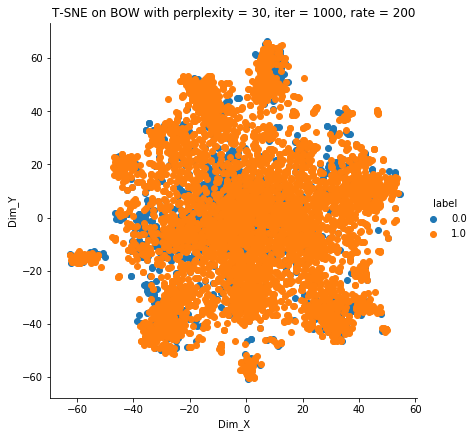

CPU times: user 54.5 s, sys: 524 ms, total: 55 s
Wall time: 54.3 s


In [44]:
%%time

from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

tsne_model = TSNE(n_components=2, random_state=0)
# configuring the parameteres
# the number of components = 2
# default perplexity = 30
# default learning rate = 200
# default Maximum number of iterations for the optimization = 1000

tsne_data = tsne_model.fit_transform(tsvd_data)

# creating a new data frame which help us in ploting the result data
tsne_data = np.vstack((tsne_data.T, score)).T
tsne_df = pd.DataFrame(data=tsne_data, columns=("Dim_X", "Dim_Y", "label"))

# Plotting the result of tsne
sns.FacetGrid(tsne_df, hue="label", height=6).map(plt.scatter, "Dim_X", "Dim_Y").add_legend()
plt.title('T-SNE on BOW with perplexity = 30, iter = 1000, rate = 200')
plt.show()

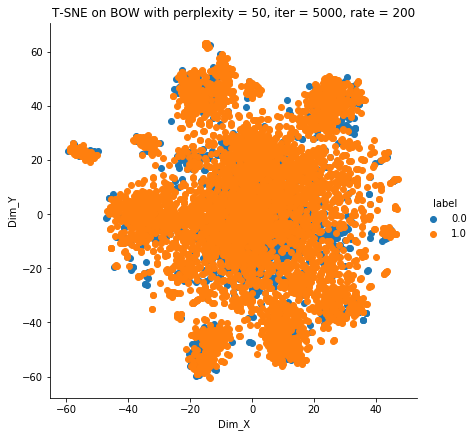

In [46]:
#Adjust the hyper parameters of T-SNE in an effort to find a stable  model

# perplexity = 50
# default learning rate = 200
# Maximum number of iterations for the optimization = 5000 for getting a shot at a converged model.
tsne_model_50_5000 = TSNE(n_components=2, random_state=0,perplexity=50,n_iter=5000)

tsne_data = tsne_model_50_5000.fit_transform(tsvd_data)

# creating a new data frame which help us in ploting the result data
tsne_data = np.vstack((tsne_data.T, score)).T
tsne_df = pd.DataFrame(data=tsne_data, columns=("Dim_X", "Dim_Y", "label"))

# Plotting the result of tsne
sns.FacetGrid(tsne_df, hue="label", height=6).map(plt.scatter, "Dim_X", "Dim_Y").add_legend()
plt.title('T-SNE on BOW with perplexity = 50, iter = 5000, rate = 200')
plt.show()

## Observations

1. T-SNE with the BOW approach was run to get different plots by adjusting its hyperparameters.
2. There is a huge amount of overlapping between positive and negative reviews and they cannot be visually separated by the BOW approach.